In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
plt.rcParams['font.sans-serif'] = ['SimHei'] #SimHei黑体
plt.rcParams['axes.unicode_minus'] = False  #False 状态下可以显示负数


columns = ["user_id", "order_dt", "order_products", "order_amount"]
#用户id、购买日期、购买产品数、购买金额
df = pd.read_table('CDNOW_master.txt', names = columns, sep="\s+") #sep对于分割符的匹配

In [96]:
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [97]:
df.info()  #日期格式有问题

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         69659 non-null  int64  
 1   order_dt        69659 non-null  int64  
 2   order_products  69659 non-null  int64  
 3   order_amount    69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [98]:
df.describe()

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


* 大部分订单只消费了少量商品（平均2.4）,有一定极值干扰
* 用户大量的消费金额比较稳定，平均消费35元中位数在35元

In [99]:
df["order_dt"] = pd.to_datetime(df.order_dt, format = "%Y%m%d")
df["month"] = df.order_dt.values.astype("datetime64[M]")

In [100]:
df.head()

,user_id,order_dt,order_products,order_amount,month
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         69659 non-null  int64         
 1   order_dt        69659 non-null  datetime64[ns]
 2   order_products  69659 non-null  int64         
 3   order_amount    69659 non-null  float64       
 4   month           69659 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 2.7 MB


# 1、进行用户消费趋势的分析(按月)

* 每月消费总金额
* 每月的消费次数
* 每月的产品购买数量
* 每月的消费人数

## 1.1 每月消费总金额

In [102]:
grouped_month = df.groupby("month")
order_month_amount = grouped_month.order_amount.sum()
order_month_amount.head()

month
1997-01-01    299060.17
1997-02-01    379590.03
1997-03-01    393155.27
1997-04-01    142824.49
1997-05-01    107933.30
Name: order_amount, dtype: float64

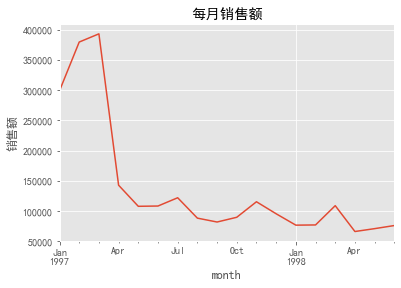

In [103]:
plt.title('每月销售额')
plt.ylabel('销售额')
order_month_amount.plot()

由上图可知，消费金额在前三个月达到最高峰，后续消费额较为稳定，有轻微下降趋势

## 1.2 每月的消费次数

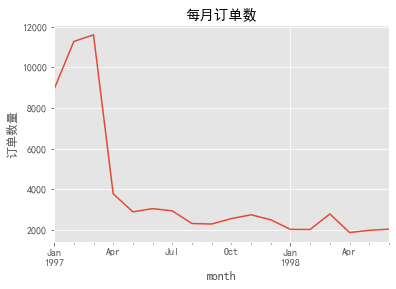

In [104]:
plt.title('每月订单数')
plt.ylabel('订单数量')
grouped_month.user_id.count().plot()

前三个月订单数在10000笔左右，后续月份的平均消费人数则在2500人

## 1.3 每月的产品购买数量

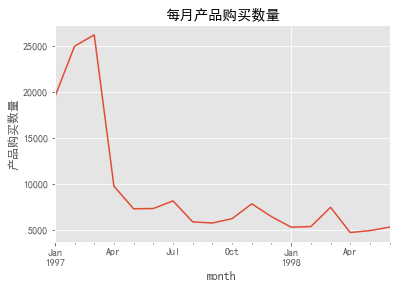

In [105]:
plt.title('每月产品购买数量')
plt.ylabel('产品购买数量')
grouped_month.order_products.sum().plot()

由上图可知，前三个月产品购买数量在20000左右，后续月份购买数量下滑，在5500左右，且有递减趋势。

## 1.4 每月的消费人数

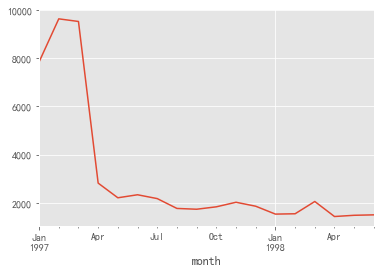

In [106]:
df.groupby("month").user_id.apply(lambda x: len(x.drop_duplicates())).plot()

由上图可知，每月消费人数低于每月消费次数，但差异不大

前三个月每月的消费人数在8000~10000之间，后续月份平均消费人数在2000人左右

* 数据透视表

In [107]:
df.pivot_table(index = 'month',
              values = ['order_products','order_amount','user_id'],
              aggfunc = { 'order_products':'sum',
                         'order_amount':'sum',
                         'user_id':'count'              
              }).head()

,order_amount,order_products,user_id
month,,,
1997-01-01,299060.17,19416,8928
1997-02-01,379590.03,24921,11272
1997-03-01,393155.27,26159,11598
1997-04-01,142824.49,9729,3781
1997-05-01,107933.30,7275,2895


# 2、用户个体消费分析
* 用户消费金额，消费次数的描述统计
* 用户消费金额和消费的散点图
* 用户消费金额的分布图
* 用户消费次数的分布图
* 用户累计消费金额占比（百分之多少的用户占了百分之多少的消费金额）

## 2.1 用户消费金额，消费次数的描述统计

In [108]:
grouped_user = df.groupby("user_id")

In [109]:
grouped_user.sum()

,order_products,order_amount
user_id,,
1,1,11.77
2,6,89.00
3,16,156.46
4,7,100.50
5,29,385.61
...,...,...
23566,2,36.00
23567,1,20.97
23568,6,121.70


In [110]:
grouped_user.sum().describe()

,order_products,order_amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


* 用户平均购买了7张CD，但是中位值只有3，说明小部分用户购买了大量的CD
* 用户平均消费106元， 中位值有43元， 判断同上， 有极致干扰
* 75%分位点购买数量为7，和均值相同，说明有25%的人买了大于7张CD。

## 2.2 用户消费金额和消费的散点图

Text(0.5, 0, '购买金额')

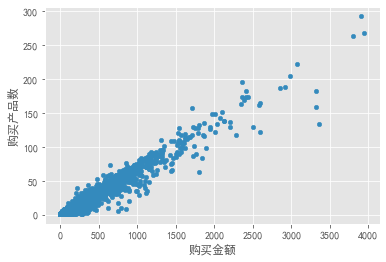

In [111]:
grouped_user.sum().query("order_amount< 4000").plot.scatter(x = "order_amount", y = "order_products")
plt.ylabel('购买产品数')
plt.xlabel('购买金额')
# query函数类似于SQL  where 的功能
# scatter散点图一般揭示的都是规律

## 2.3 用户消费金额的分布图

Text(0.5, 1.0, '用户消费金额分布图')

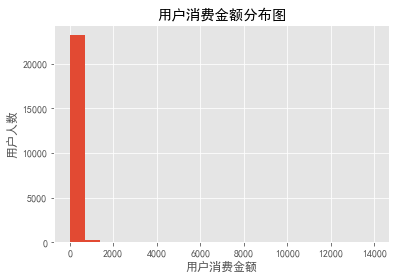

In [112]:
grouped_user.sum().order_amount.plot.hist(bins = 20)
plt.xlabel('用户消费金额')
plt.ylabel('用户人数')
plt.title('用户消费金额分布图')
# hist直方图
# bins意思为把整个x轴分为20块

由直方图可知，用户消费金额，绝大部分呈现集中趋势，小部分异常值干扰了判断，可以使用过滤操作排除异常

## 2.4 用户购买数量分布图

Text(0.5, 1.0, '用户购买数量分布图')

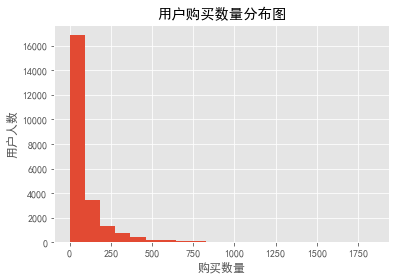

In [113]:
grouped_user.sum().query("order_products<90").order_amount.plot.hist(bins = 20)
plt.xlabel('购买数量')
plt.ylabel('用户人数')
plt.title('用户购买数量分布图')

使用切比雪夫定理过滤掉异常值，计算95%的数据的分布情况

从直方图可知，用户消费金额，绝大部分呈现集中趋势，大部分购买CD数20张内，高消费用户在图上几乎看不到，这是符合消费行为的行业规律。

## 2.5 用户累计消费金额占比

Text(0.5, 1.0, '用户累计消费金额占比')

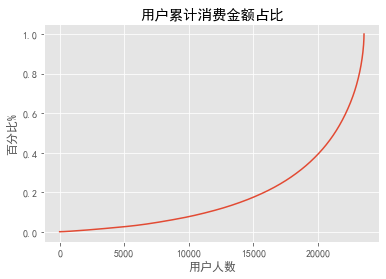

In [114]:
user_cumsum = grouped_user.sum().sort_values("order_amount").apply(lambda x: x.cumsum()/x.sum())
user_cumsum.reset_index().order_amount.plot()
plt.xlabel('用户人数')
plt.ylabel('百分比%')
plt.title('用户累计消费金额占比')

通过分析累计销售额占比，从图中不难看出用户消费行为基本符合二八定律，80% 的用户贡献了 25% 的消费金额，而 60% 的消费由前 5000 名用户贡献。所以只要维护了这5000 名用户,就能完成 60% 的KPI。

# 3. 用户消费行为

* 用户第一次消费（首购）
* 用户最后一次消费
* 用户分层
* RFM模型
* 新、活跃、回流、流失/不活跃
* 用户购买周期（按订单）
* 用户消费周期描述
* 用户消费周期分布
* 用户生命周期（按第一次&最后一次消费）
* 用户生命周期描述
* 用户生命周期分布

## 3.1 用户第一次消费（首购）

Text(0, 0.5, '人数')

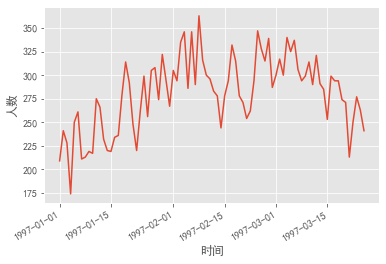

In [115]:
grouped_user.min().order_dt.value_counts().plot()
plt.xlabel('时间')
plt.ylabel('人数')

用户第一次购买分布，集中在前三个月

其中，在2月11日至2月25日有一次剧烈的波动

In [116]:
grouped_user.min().order_dt.value_counts().head()

1997-02-08    363
1997-02-24    347
1997-02-04    346
1997-02-06    346
1997-03-04    340
Name: order_dt, dtype: int64

## 3.2 用户最后一次消费

Text(0, 0.5, '人数')

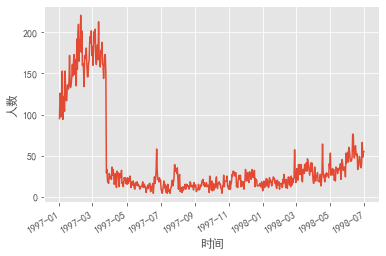

In [117]:
grouped_user.max().order_dt.value_counts().plot()
plt.xlabel('时间')
plt.ylabel('人数')

用户最后一次购买的分布比第一次广大部分用户最后一次购买，

集中在前三个月，说明有很多用户购买了一次后就不再进行购买

随着时间的递增，最后一次购买数也在递增，消费呈现流失上升的状况

In [118]:
user_life = grouped_user.order_dt.agg(['min','max'])
user_life.head()

,min,max
user_id,,
1,1997-01-01,1997-01-01
2,1997-01-12,1997-01-12
3,1997-01-02,1998-05-28
4,1997-01-01,1997-12-12
5,1997-01-01,1998-01-03


In [119]:
(user_life['min'] == user_life['max']).value_counts()

True     12054
False    11516
dtype: int64

有一半用户就消费了一次

## 3.3 用户分层

### 3.3.1 构建RFM模型

In [120]:
rfm = df.pivot_table(index = 'user_id',
                    values = ['order_products','order_amount','order_dt'],
                    aggfunc = {'order_dt':'max',
                              'order_amount':'sum',
                              'order_products':'sum'})
rfm.head()

,order_amount,order_dt,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,6
3,156.46,1998-05-28,16
4,100.50,1997-12-12,7
5,385.61,1998-01-03,29


In [121]:
rfm['R'] = -(rfm.order_dt - rfm.order_dt.max())/np.timedelta64(1,'D')  #去除天数的单位，方便计算
rfm.rename(columns = {'order_products':'F','order_amount':'M'},inplace = True)
rfm.head()

,M,order_dt,F,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,6,534.0
3,156.46,1998-05-28,16,33.0
4,100.50,1997-12-12,7,200.0
5,385.61,1998-01-03,29,178.0


In [127]:
def rfm_func(x):
    level = x.apply(lambda x: '1' if x >= 0 else '0')
    label = level.R + level.F + level.M
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要发展客户',
        '001':'重要挽留客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般发展客户',
        '000':'一般挽留客户'
    }
    result = d[label]
    return result

rfm['label'] = rfm[['R','F','M']].apply(lambda x: x - x.mean()).apply(rfm_func,axis=1)

In [128]:
rfm.head()

,M,order_dt,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般发展客户
2,89.00,1997-01-12,6,534.0,一般发展客户
3,156.46,1998-05-28,16,33.0,重要保持客户
4,100.50,1997-12-12,7,200.0,一般挽留客户
5,385.61,1998-01-03,29,178.0,重要保持客户


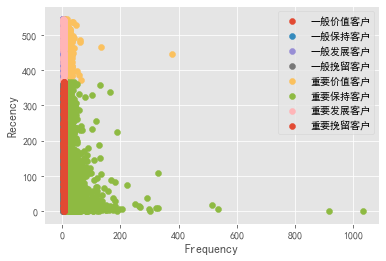

In [129]:
for label,gropued in rfm.groupby('label'):
    x= gropued['F']
    y = gropued['R']
    
    plt.scatter(x,y,label = label) # 利用循环绘制函数
plt.legend(loc='best') # 图例位置
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.savefig('./11',bbox_inches = 'tight')

In [130]:
rfm.groupby('label').count()  

,M,order_dt,F,R
label,,,,
一般价值客户,77,77,77,77
一般保持客户,206,206,206,206
一般发展客户,14074,14074,14074,14074
一般挽留客户,3300,3300,3300,3300
重要价值客户,787,787,787,787
重要保持客户,4554,4554,4554,4554
重要发展客户,241,241,241,241
重要挽留客户,331,331,331,331


In [131]:
rfm.groupby('label').sum()

,M,F,R
label,,,
一般价值客户,7181.28,650,36295.0
一般保持客户,19937.45,1712,29448.0
一般发展客户,438291.81,29346,6951815.0
一般挽留客户,196971.23,13977,591108.0
重要价值客户,167080.83,11121,358363.0
重要保持客户,1592039.62,107789,517267.0
重要发展客户,33028.40,1263,114482.0
重要挽留客户,45785.01,2023,56636.0


从RFM分层可知，大部分用户为重要保持用户，但是这是由于极值的影响，所以RFM分层的划分标准应该以业务为准

* 尽量用小部分的用户覆盖大部分的额度
* 不要为了数据好看划分等级

### 3.3.2 按照新、活跃、回流、流失分层用户

In [132]:
pivoted_counts = df.pivot_table(index = 'user_id',
                               columns = 'month',
                               values = 'order_dt',
                               aggfunc = 'count').fillna(0)
pivoted_counts.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [133]:
df_purchase = pivoted_counts.applymap(lambda x : 1 if x >0 else 0)
df_purchase.tail()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
23566,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23567,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23568,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23569,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [134]:
def active_status(data):
    status =[]
    for i in range(18):
        
        #若本月没有消费
        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
        
        #若本月有消费
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1]== 'unreg':
                    status.append('new')
                else:
                    status.append('active')
                    
    data = data.astype('object')
    for i in range(18):
        data[i] = status[i]
        
    return data

若本月没有消费
* 若之前是未注册，则依旧是未注册
* 若之前有消费，则为流失/不活跃
* 其他情况，为未注册
若本月有消费
* 若是第一次消费，则为新用户
* 如果之前有过消费，且上个月为不活跃，则为回流
* 如果上个月为未注册，则为新用户
* 除此之外，为活跃

In [135]:
purchase_stats = df_purchase.apply(active_status,axis = 1)
purchase_stats.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [136]:
purchase_stats_ct = purchase_stats.replace('unreg',np.NaN).apply(lambda x: pd.value_counts(x))
purchase_stats_ct

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


新用户前三月较多，后期没有增加，流失用户逐渐增加，回流用户和活跃用户逐渐减少

In [137]:
purchase_stats_ct.fillna(0).T.head()

,active,new,return,unactive
month,,,,
1997-01-01,0.0,7846.0,0.0,0.0
1997-02-01,1157.0,8476.0,0.0,6689.0
1997-03-01,1681.0,7248.0,595.0,14046.0
1997-04-01,1773.0,0.0,1049.0,20748.0
1997-05-01,852.0,0.0,1362.0,21356.0


<Figure size 1440x889.92 with 0 Axes>

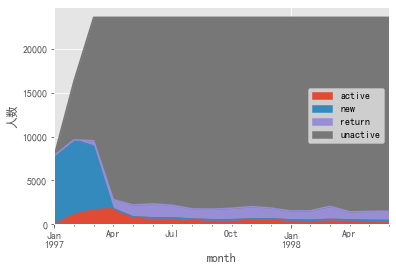

In [138]:
plt.figure(figsize=(20, 0.618*20))
purchase_stats_ct.fillna(0).T.plot.area() #绘制面积图
plt.ylabel('人数')
plt.savefig('./12',bbox_inches = 'tight')

由面积图，蓝色和灰色区域占大面积，可以不看，因为这只是某段时间消费过的用户的后续行为。其次红色代表的活跃用户非常稳定，是属于核心用户，以及紫色的回流用户，这两个分层相加，就是消费用户人数占比（后期没有新增用户）

* 各类用户的占比

In [141]:
purchase_stats_ct.fillna(0).T.apply(lambda x: x/ x.sum(),axis = 1) #各类用户的占比

,active,new,return,unactive
month,,,,
1997-01-01,0.000000,1.000000,0.000000,0.000000
1997-02-01,0.070886,0.519299,0.000000,0.409815
1997-03-01,0.071319,0.307510,0.025244,0.595927
1997-04-01,0.075223,0.000000,0.044506,0.880272
1997-05-01,0.036148,0.000000,0.057785,0.906067
1997-06-01,0.031693,0.000000,0.067543,0.900764
1997-07-01,0.031650,0.000000,0.060840,0.907510
1997-08-01,0.025626,0.000000,0.049555,0.924820
1997-09-01,0.022401,0.000000,0.051379,0.926220


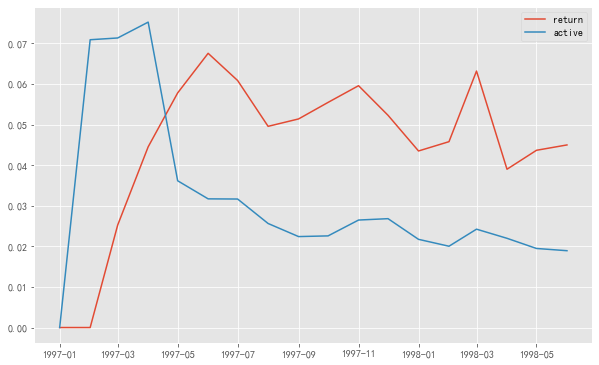

In [142]:
plt.figure(figsize=(10, 10*0.618))
rate = purchase_stats_ct.fillna(0).T.apply(lambda x: x/ x.sum(),axis = 1)
plt.plot(rate['return'],label='return')
plt.plot(rate['active'],label='active')
plt.legend()
plt.savefig('./13',bbox_inches = 'tight')

由上表可知，每月的用户消费状态变化
* 回流用户比：某个时间段内回流用户在总用户中的占比
 - 由图可知，用户每月回流用户比占 5% ～ 8% 之间，有下降趋势，说明客户有流失倾向。
* 回流用户率：上月有多少不活跃用户在本月消费
 - 由于这份数据的不活跃用户量基本不变，所以这里的回流率，也近似等于回流比
* 活跃用户比：某个时间段内活跃用户在总用户中的占比.
 - 活跃用户的占比在 3% ～ 5%间，下降趋势更显著，活跃用户可以看作连续消费用户，忠诚度高于回流用户。

结合活跃用户和回流用户看，在后期的消费用户中，60%是回流用户，40%是活跃用户，整体用户质量相对不错。也进一步说明前面用户消费行为分析中的二八定律，反映了在消费领域中，狠抓高质量用户是不变的道理。